In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os, fnmatch, re
import math
import sys
import re

The following reads in the functions defined in the `python` file galCoords.py, which you will use later on in the Notebook.

In [4]:
sys.path.append('/content/drive/MyDrive/Galactic Rotation/data')
from galCoords import *

The following cell defines the variables Rsun (distance of the Sun from the Galactic Center, given in kpc) and Vsun (circular velocity of the Sun around the Galactic Center, given in km/s)

In [5]:
Rsun = 8
Vsun = 220

You now know how to recover a 21 cm spectrum from the data, with backgrounds and spurs removed. This week, we will use these results to build a 'heat map' from which we will ultimately deduce the rotation curve of the Galaxy. To achieve this, we will use data taken with the 60’ Camp Evans telescope in the spectrum mode. For details on this data format, see the ‘Data Format Reference’ document.  

(Data and exercises kindly provided by D. Marlow)

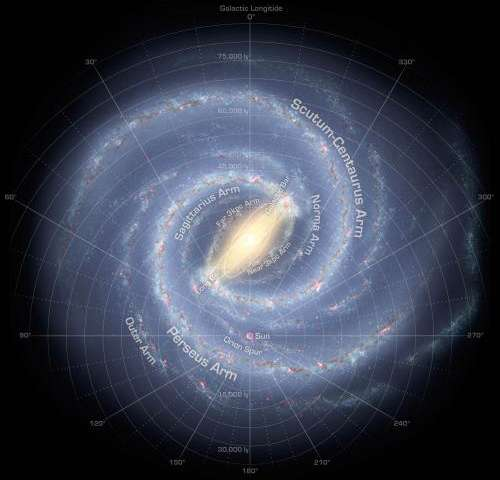

Begin by reading in the gain file, `gLon_gain.dat`

In [6]:
def getGain():
  fileName = "/content/drive/MyDrive/Galactic Rotation/data/gLon_gain.dat"
  gain = np.fromfile(fileName,dtype=float)
  return gain

Each data file corresponds to a 120 second run with the telescope fixed on a particular galactic longitude $\ell$ lying along the galactic equator ($b = 0^\circ$). The naming scheme for the files is e.g., `gLon022_001.dat`, where `gLon022` means that the data was taken at a galactic longitude of $\ell= 22^\circ$. The `001` just means that it is the first such run at this point.

To warm up, read in `gLon000_001.dat` and plot the background-subtracted gain-corrected power spectrum. Feel free to copy over any functions from last week's notebook that may be of use.

(Note that the power that is read has already been converted to temperature, and is in units of K.)

In [7]:
gain = getGain()

2048


Text(0, 0.5, 'Power')

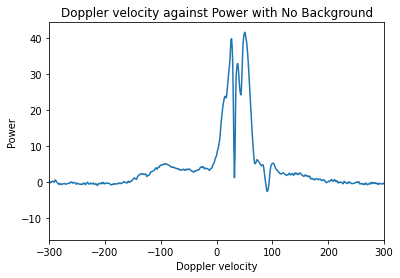

In [18]:
def getHeaderDictionary(header) :
    headerDict = {}
    headerDict['timeStampMegaSec'] = header[0] 
    headerDict['timeStampSec'] =  header[1] 
    headerDict['timeStamp'] = 1.e6*header[0] + header[1]
    headerDict['nBins'] = int(header[2]) 
    headerDict['nSamples'] = int(header[3]) 
    headerDict['timeStep'] = header[4]  
    headerDict['fCenter'] = header[5] 
    headerDict['fSample'] = header[6] 
    headerDict['gain'] = header[7] 
    headerDict['nAverage'] = header[8] 
    return headerDict

fileName = "/content/drive/MyDrive/Galactic Rotation/data/gLon000_001.dat"
data = np.fromfile(fileName,dtype=float)
header = data[0:16]
headerDict = getHeaderDictionary(header)
power = data[16:]
print(len(power))

fCenter = headerDict['fCenter']
fSample = headerDict['fSample']
fMin = fCenter - (fSample)/2
fMax = fCenter + (fSample)/2

freqs = np.linspace(fMin,fMax,headerDict['nBins'])
vDoppler = (3*10**5)*(freqs-1420.41)/freqs

power_gaincorrected = np.divide(power,gain)

def removeSpurs(x):
  spurChannels = [612,613,614,615,616,617]
  x1 = np.delete(x, spurChannels)
  return x1

power_gaincorrected_nospur = removeSpurs(power_gaincorrected)
vDoppler = removeSpurs(vDoppler)
"""
plt.plot(vDoppler, power_gaincorrected_nospur)
plt.xlim(-300,300)
plt.title("Doppler velocity against Power with No Spurs")
plt.xlabel("Doppler velocity km/s")
plt.ylabel("Power")
"""
def getBackground(vDoppler,power) :
    N = len(vDoppler)
    v1, v2 = -300., 300.
    i1 = np.searchsorted(vDoppler,v1)
    i2 = np.searchsorted(vDoppler,v2)
    
    m = (power[i2]-power[i1])/(v2-v1)
    b = power[i1] - m*v1
    background = (m*vDoppler)+b
    
    return background
  
background = getBackground(vDoppler,power_gaincorrected_nospur)
power_no_background = power_gaincorrected_nospur-background

plt.plot(vDoppler, power_no_background)
plt.xlim(-300,300)
plt.title("Doppler velocity against Power with No Background")
plt.xlabel("Doppler velocity (km/s)")
plt.ylabel("Power (K)")

You will need to extract the longitude associated with each data file from its filename. To do so, use pattern matching with regular expressions:

```
import re

regex = r"gLon([0-9]+)_.*"

gLon = re.match(regex, <filename>)

L = float(gLon[1])
```
    
The second line defines the regular expression; this is a shorthand for picking out any collection of numbers from 0–9 that are sandwiched between a 'gLon' and a '_'. The third line looks for the match of this regular expression in a given string (the filename, in this instance). The last line takes the string of numbers that was selected, converts them to a float and saves them as the variable 'L'. Use this code snippet on the file analyzed above to make sure that your code is indeed picking out the correct longitude value associated with each file. (Note that the `import re` command, like all `import` commands, should go at the top of your notebook.)

In [23]:
regex = r"gLon([0-9]+)_.*"

gLon = re.match(regex, "gLon000_001.dat")
 
L = float(gLon[1])

Next, we would like to read in all the data files in the directory and perform the same set of operations on each one.  To do so, we will use the following code snippet:

```
for file in sorted(os.listdir(<data directory>)):

  if fnmatch.fnmatch(file, ‘*[0-9]_*.dat’):

    <your code goes here>
```

The `os.listdir(<data directory>)` lists all files in the data directory. The `for loop` will contain the series of actions that are applied to every file in the directory. The `fnmatch.fnmatch(file, '*[0-9]_*.dat')` command checks to see if the filename contains the following pattern: 

*   any set of digits from 0–9 preceded by anything (denoted by *)
*   and followed by a '_'
*   and anything else (denoted again by *)

The `if loop` only proceeds if the filename matches this pattern. As a test, you can print out the filenames to verify that the `for loop` only acts on the data files, and not the gain file.  

Next, edit the `for loop` so that each iteration does the following:

1. Read the raw power array.
2. Correct for the gain.
3. Remove the spurs.
4. Subtract the background.
5. Define the Doppler velocity array.
6. Find the longitude associated with each file.

In [27]:
for file in sorted(os.listdir("/content/drive/MyDrive/Galactic Rotation/data")):
  
  if fnmatch.fnmatch(file, "*[0-9]_*.dat"):
    data = np.fromfile("/content/drive/MyDrive/Galactic Rotation/data/"+file,dtype=float)
    header = data[0:16]
    headerDict = getHeaderDictionary(header)
    power = data[16:]

    fCenter = headerDict['fCenter']
    fSample = headerDict['fSample']
    fMin = fCenter - (fSample)/2
    fMax = fCenter + (fSample)/2

    freqs = np.linspace(fMin,fMax,headerDict['nBins'])
    vDoppler = (3*10**5)*(freqs-1420.41)/freqs

    power_gaincorrected = np.divide(power,gain)

    power_gaincorrected_nospur = removeSpurs(power_gaincorrected)
    vDoppler = removeSpurs(vDoppler)
      
    background = getBackground(vDoppler,power_gaincorrected_nospur)
    power_no_background = power_gaincorrected_nospur-background
    
    gLon = re.match(regex, file)
    L = float(gLon[1])

Now you need to save the longitude values to an array. To do so, create an empty array outside the `for loop` as follows:

`gLon_array = np.zeros(<number of data files>)`

To fill in this array, add the following code snippet inside the `for loop`:

`gLon_array[nfile] = L`

`nFile` is an index that keeps track of the file number. To initialize its value, set `nFile = 0` outside the `for loop`. Increase the value of `nFile` by one for each iteration of the loop. Verify that the array of longitude values built in this way is correct.

In [39]:
nFile = 0
gLon_array = np.zeros(43)
for file in sorted(os.listdir("/content/drive/MyDrive/Galactic Rotation/data")):
  
  if fnmatch.fnmatch(file, "*[0-9]_*.dat"):
    data = np.fromfile("/content/drive/MyDrive/Galactic Rotation/data/"+file,dtype=float)
    header = data[0:16]
    headerDict = getHeaderDictionary(header)
    power = data[16:]

    fCenter = headerDict['fCenter']
    fSample = headerDict['fSample']
    fMin = fCenter - (fSample)/2
    fMax = fCenter + (fSample)/2

    freqs = np.linspace(fMin,fMax,headerDict['nBins'])
    vDoppler = (3*10**5)*(freqs-1420.41)/freqs

    power_gaincorrected = np.divide(power,gain)

    power_gaincorrected_nospur = removeSpurs(power_gaincorrected)
    vDoppler = removeSpurs(vDoppler)
      
    background = getBackground(vDoppler,power)
    power_no_background = power_gaincorrected_nospur-background
    
    gLon = re.match(regex, file)
    L = float(gLon[1])
    gLon_array[nFile] = L
    nFile += 1

print(gLon_array)


[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60. 62. 64. 66. 68. 70.
 72. 74. 76. 78. 80. 82. 84.]


We need some way to summarize all of this information compactly.  To do so, we will make a `heat map` with `Longitude` plotted on the y-axis, `Doppler Velocity` plotted on the x-axis and the color of each bin associated with `Power`.  This requires saving the data that we read into a 2D array.

Determine the number of files that are being read in, as well as the length of the Doppler velocity array. Define a two-dimensional array of zeros where each row corresponds to the file number and each column corresponds to the Doppler velocity:
 
```
nRows, nCols = <number of data files> , <length of Doppler array>

mapData = np.zeros((nRows, nCols))
```
 
Note that this code snippet should be placed above the `for loop` defined above.

Following a procedure similar to that above, fill in the `mapData` array. However, there are two indices that need to be defined, one that is associated with the file index, `nFile`, and the other associated with the Doppler velocity. You can use another `for loop` to do this:

```
for j in range(len( <despurred Doppler array> )):
     mapData[nfile][j] =  <fill in>
```

Remove any negative values for the gain-corrected power using a statement such as

```power = np.maximum(0., power)```

Plot a 2D histogram of the temperature data as follows:
    
```
plt.figure(figsize=(10.,7.5))

plt.pcolormesh( <Doppler array>, <Longitude array>, mapData)

cb = plt.colorbar()

cb.set_label(‘Temperature [K]’)

plt.show()
```

Be sure to label your axes appropriately and give your plot a title. Only show results for `300 < vDoppler < 300 km/s`.    

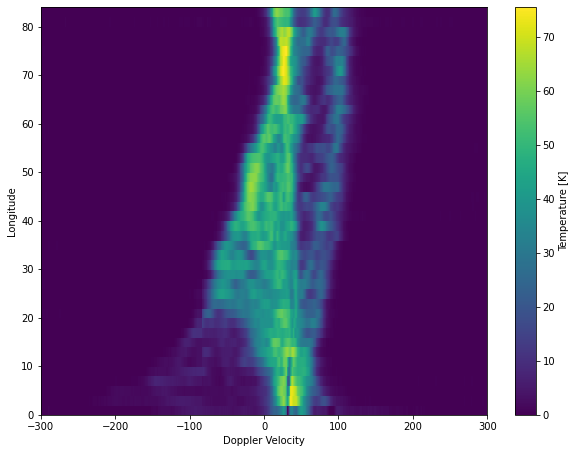

In [60]:
gLon_array = np.zeros(43)
nRows, nCols = 43, len(vDoppler)
mapData = np.zeros((nRows, nCols))
nfile = 0

for file in sorted(os.listdir("/content/drive/MyDrive/Galactic Rotation/data")):
  
  if fnmatch.fnmatch(file, "*[0-9]_*.dat"):
    data = np.fromfile("/content/drive/MyDrive/Galactic Rotation/data/"+file,dtype=float)
    header = data[0:16]
    headerDict = getHeaderDictionary(header)
    power = data[16:]

    fCenter = headerDict['fCenter']
    fSample = headerDict['fSample']
    fMin = fCenter - (fSample)/2
    fMax = fCenter + (fSample)/2

    freqs = np.linspace(fMin,fMax,headerDict['nBins'])
    vDoppler = (3*10**5)*(freqs-1420.41)/freqs

    power_gaincorrected = np.divide(power,gain)

    power_gaincorrected_nospur = removeSpurs(power_gaincorrected)
    vDoppler = removeSpurs(vDoppler)
      
    background = getBackground(vDoppler,power_gaincorrected_nospur)
    power_no_background = power_gaincorrected_nospur-background
    power_final = np.maximum(0., power_no_background)
    
    gLon = re.match(regex, file)
    L = float(gLon[1])
    gLon_array[nfile] = L
    
    for j in range(len(vDoppler)):
      mapData[nfile][j] =  power_final[j]
    nfile += 1

plt.figure(figsize=(10.,7.5))
plt.xlim(-300,300)
plt.pcolormesh(vDoppler, gLon_array, mapData)
plt.xlabel("Doppler Velocity (km/s)")
plt.ylabel("Longitude (degrees)")
cb = plt.colorbar()
cb.set_label("Temperature [K]")
plt.show()
plt.title("Heat Map of Longitude against Doppler Velocity")

The folder you downloaded contains the module `galCoords`, which is imported above.

Use it to calculate the velocity of the Earth in the direction in which the telescope is pointing. The calling sequence is

`vE = velocityProjection( fileTime, ‘G’, L, 0.)`

where `L` is the galactic longitude in degrees. The final argument, which is 0., is the galactic latitude. The `G` specifies that we are using galactic coordinates. `fileTime` is the time stamp extracted from the data header as follows

```ts = header[0]*1.e6 + header[1]```

Add points to the heat map corresponding to the values of the Earth velocity at a given longitude.


In [48]:
fileTime = header[0]*1.e6 + header[1]
vE = velocityProjection(fileTime, "G", L, 0.)

Next, find the leftmost point in each spectrum that is above the background. You can call this `vPrime_uncorrected`. This is the uncorrected minimum velocity of approach, which is the same as the maximum velocity of recession (what we will ultimately need). To do this, scan the power array from the left, finding the first point where the power exceeds 20 K above background. Note: Use of `np.searchsorted()` is not a good option here, since it will return the channel number of the point that is closest to 20 K, which could occur anywhere in the spectrum. Here, we want the first channel (from the left) that goes above 20 K.

Add points to the heat map corresponding to `vPrime_uncorrected`.

In [73]:
def find20(array):
    i = 0
    while (i < len(array)):
      if array[i] >= 20:
        return i
      i+=1
    return i

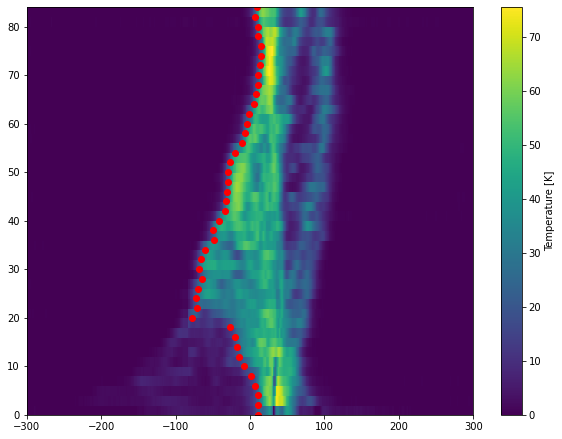

In [77]:
gLon_array = np.zeros(43)
nRows, nCols = 43, len(vDoppler)
mapData = np.zeros((nRows, nCols))
vPrime_uncorrected = np.zeros(43)
nfile = 0


for file in sorted(os.listdir("/content/drive/MyDrive/Galactic Rotation/data")):
  
  if fnmatch.fnmatch(file, "*[0-9]_*.dat"):
    data = np.fromfile("/content/drive/MyDrive/Galactic Rotation/data/"+file,dtype=float)
    header = data[0:16]
    headerDict = getHeaderDictionary(header)
    power = data[16:]

    fCenter = headerDict['fCenter']
    fSample = headerDict['fSample']
    fMin = fCenter - (fSample)/2
    fMax = fCenter + (fSample)/2

    freqs = np.linspace(fMin,fMax,headerDict['nBins'])
    vDoppler = (3*10**5)*(freqs-1420.41)/freqs

    power_gaincorrected = np.divide(power,gain)

    power_gaincorrected_nospur = removeSpurs(power_gaincorrected)
    vDoppler = removeSpurs(vDoppler)
      
    background = getBackground(vDoppler,power_gaincorrected_nospur)
    power_no_background = power_gaincorrected_nospur-background
    power_final = np.maximum(0., power_no_background)



    gLon = re.match(regex, file)
    L = float(gLon[1])
    gLon_array[nfile] = L
    
    vPrime_uncorrected[nfile] = vDoppler[find20(power_final)]

    for j in range(len(vDoppler)):
      mapData[nfile][j] =  power_final[j]
    nfile += 1

plt.figure(figsize=(10.,7.5))
plt.xlim(-300,300)
plt.pcolormesh(vDoppler, gLon_array, mapData)
plt.plot(vPrime_uncorrected, gLon_array, 'ro', label = "V_prime uncorrected")
cb = plt.colorbar()
plt.xlabel("Doppler Velocity (km/s)")
plt.ylabel("Longitude (degrees)")
cb.set_label("Temperature [K]")
plt.show()
plt.title("Heat Map of Longitude against Doppler Velocity")
plt.label()

Following the notes on Galactic Rotation curves, calculate $v'_\mathrm{corrected}$, $r$, and $v(r)$. The corrected version of $v'$ is $v'_\mathrm{corrected} = - (v'_\mathrm{uncorrected} - v_E) = v_E - v'_\mathrm{uncorrected}$, where $v_E$ is the Earth's velocity. The first minus sign in this equation comes about because the value in the data plots is velocity of approach, whereas the rotation curve analysis assumes velocity of recession. When calculating the rotation velocity, use the following expression for $v(r)$:

$v(r) = v' + R_\odot \Omega_\odot \sin \ell $

where $R_\odot = 8$ kpc is the Solar radius, $\Omega_\odot$ is the angular velocity of the Sun, and $v'$ is the corrected maximum velocity of recession. You may take the circular velocity of the Sun to be $V_\odot = 220$ km/s.

Plot the rotational velocity versus galactic radius. You will need to take the sine of the galactic longitude, $\ell$. In doing so, be sure that $\ell$ is being expressed in radians. The `math.radians()` function may come in handy.

In [99]:
vPrime_corrected = -(vPrime_uncorrected-vE)

radius_sun = 8

c_velocity_sun = 220

i = 0
vr = np.zeros(43)
while (i < len(gLon_array)):
  vr[i] = vPrime_corrected[i] + c_velocity_sun*np.sin(math.radians(gLon_array[i]))
  i += 1

print(v)

[ 10.85305549  11.88476731  11.88476731  14.97994534  21.17049302
  30.4567936   36.64798005  39.7436691   41.80749729  49.03111958
 100.63853935  93.41243183  94.44471159  92.38015916  86.18667231
  91.3478936   88.25113952  83.09002476  70.70407367  71.73619721
  64.51148157  56.25508972  54.19106275  53.15905992  52.12706418
  52.12706418  49.03111958  42.83942204  32.52049402  29.42495403
  26.32947792  23.23406569  17.04343285  13.94821224  10.85305549
  10.85305549   8.78965315   7.75796262   7.75796262  11.88476731
  11.88476731  14.97994534  12.91648622]


In [101]:
i = 0
r = np.zeros(43)
while (i < len(gLon_array)):
  radius = 8*np.sin(math.radians(gLon_array[i]))
  r[i] = radius
  i += 1
print(r)

[0.         0.27919597 0.55805179 0.83622771 1.11338481 1.38918542
 1.66329353 1.93537516 2.20509885 2.47213595 2.73616115 2.99685275
 3.25389314 3.50696917 3.7557725  4.         4.23935411 4.47354323
 4.70228202 4.9252918  5.14230088 5.35304485 5.55726696 5.7547184
 5.9451586  6.12835554 6.30408603 6.47213595 6.63230058 6.78438477
 6.92820323 7.06358074 7.19035237 7.30836366 7.41747084 7.51754097
 7.60845213 7.69009357 7.76236581 7.82518081 7.87846202 7.92214455
 7.95617516]


Text(0, 0.5, 'Radial Velocity (km/s)')

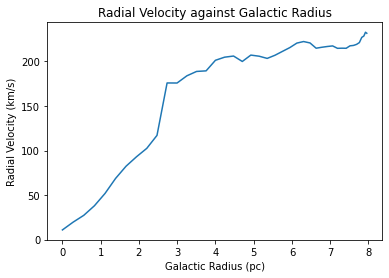

In [106]:
plt.plot(r,vr)
plt.title("Radial Velocity against Galactic Radius")
plt.xlabel("Galactic Radius (pc)")
plt.ylabel("Radial Velocity (km/s)")